In [23]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt 
import pydotplus
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from IPython.display import Image 
pd.options.display.max_columns=15
import seaborn as sns

In [ ]:
os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\AAM\Clustering")
seed = 4

In [ ]:
df = pd.read_csv(os.getcwd()+r"\Data Files\NVHGearsBLCarrier.csv")

In [26]:
df.head()

,SITENAME,PLANTNAME,LINENAME,STATIONNAME,LAPPER_STATION,BACKLASH_STATION,OP110_STN,...,'SFT 1st Mesh Harmonic Coast Side Pos 1 Val (µrad)','Single Flank Tester Spiral Angle Pinion','Single Flank Tester Spiral Angle Ring Gear',M46BPDXX_DISTANCE_D_SEAT_TO_FG,M47BPDXX_DISTANCE_DE_TO_F_SEAT,M48BPDXX_DISTANCE_DE_TO_G_SEAT,PERP_OF_AXIS_DAT_FG_TO_AXIS_DAT_DE_DAT_B_TWO_COAXIAL_HOLES
0,GMCFULL,Full Frame BU (Plant 5),NVH A&B,OP300A,GBT604077,B,110B,...,3.0684,51.083,25.066,158.5025,142.5115,105.0310,0.06390
1,GMCFULL,Full Frame BU (Plant 5),NVH A&B,OP300A,GBT702432,A,110B,...,3.1568,51.083,25.066,158.4980,142.4870,105.0190,0.00880
2,GMCFULL,Full Frame BU (Plant 5),NVH A&B,OP300B,GBT702432,A,110B,...,3.6532,51.083,25.066,158.4850,142.4860,105.0425,0.01305
3,GMCFULL,Full Frame BU (Plant 5),NVH A&B,OP300B,GBT604077,A,110A,...,2.0519,51.083,25.066,158.5055,142.4780,105.0230,0.02975
4,GMCFULL,Full Frame BU (Plant 5),NVH A&B,OP300A,GBT604077,A,110A,...,0.5989,51.083,25.066,158.4710,142.5160,105.0750,0.05240


# Data Cleaning

In [27]:
df["STATUS_ENC"]=np.where(df["STATUS"]=='A',0,1)

In [28]:
df["'Pinion Position'"] = df["'Pinion Position'"].fillna(df.groupby('TOPPART')["'Pinion Position'"].transform('median'))
df["'Pinion Head dist real'"] = df["'Pinion Head dist real'"].fillna(df.groupby('TOPPART')["'Pinion Head dist real'"].transform('median'))
df["'Single Flank Tester Spiral Angle Pinion'"] = df["'Single Flank Tester Spiral Angle Pinion'"].fillna(df.groupby(['LAPPER_STATION'])["'Single Flank Tester Spiral Angle Pinion'"].transform('median'))
df["'Single Flank Tester Spiral Angle Ring Gear'"] = df["'Single Flank Tester Spiral Angle Ring Gear'"].fillna(df.groupby(['LAPPER_STATION'])["'Single Flank Tester Spiral Angle Ring Gear'"].transform('median'))

In [29]:
df_model = df[df["TOPPART"]==84833854]

# Sample Histogram and Chi square significance for chategorical variables

In [30]:
def BVA_categorical_plot(data, tar, cat):
    '''take data and two categorical variables,
    calculates the chi2 significance between the two variables
    and prints the result with countplot & CrossTab
    '''
    #isolating the variables
    data = data[[cat,tar]][:]
    #forming a crosstab
    table = pd.crosstab(data[tar],data[cat],)
    f_obs = np.array([table.iloc[0][:].values,
    table.iloc[1][:].values])
    #performing chi2 test
    from scipy.stats import chi2_contingency
    chi, p, dof, expected = chi2_contingency(f_obs)
    #checking whether results are significant
    if p<0.05:
        sig = True
    else:
        sig = False
    #plotting grouped plot
    sns.countplot(x=cat, hue=tar, data=data)
    plt.title("p-value = {}\n difference significant? = {}\n".format(round(p,8),sig))
    #plotting percent stacked bar plot
    #sns.catplot(ax, kind='stacked')
    ax1 = data.groupby(cat)[tar].value_counts(normalize=True).unstack()
    ax1.plot(kind='bar', stacked='True',title=str(ax1))
    int_level = data[cat].value_counts()

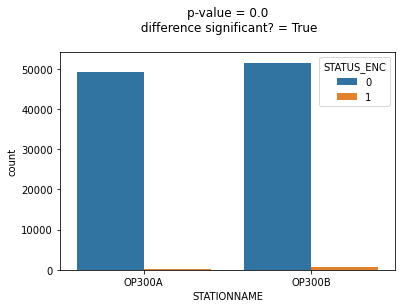

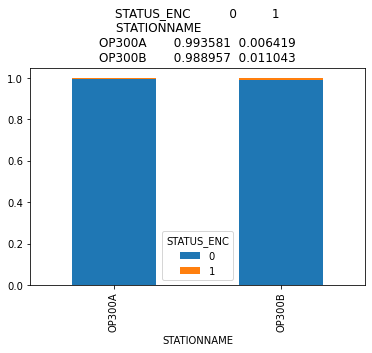

In [31]:
BVA_categorical_plot(data = df, tar = "STATUS_ENC", cat="STATIONNAME")

In [32]:
def TwoSampleZ(X1, X2, sigma1, sigma2, N1, N2):
    '''
    function takes mean, standard dev., and no. of observations and returns: p-value calculated  for 2-sampled Z-Test
    '''
    from numpy import sqrt, abs, round
    from scipy.stats import norm
    ovr_sigma = sqrt(sigma1**2/N1 + sigma2**2/N2)
    z = (X1 - X2)/ovr_sigma
    pval = 2*(1 - norm.cdf(abs(z)))
    return pval

def Bivariate_cont_cat(data, cont, cat, category):
    #creating 2 samples
    x1 = data[cont][data[cat]==category][:] # all categorical features
    x2 = data[cont][~(data[cat]==category)][:] # all continuous features
    #calculating descriptives
    n1, n2 = x1.shape[0], x2.shape[0]
    m1, m2 = x1.mean(), x2.mean() # calculates mean
    std1, std2 = x1.std(), x2.mean() # calculates standard deviation
    #calculating p-values
    z_p_val = TwoSampleZ(m1, m2, std1, std2, n1, n2)
    #table
    table = pd.pivot_table(data=data, values=cont, columns=cat, aggfunc = np.mean)
    #plotting
    plt.figure(figsize = (15,6), dpi=140)
    #barplot
    plt.subplot(1,2,1)
    sns.barplot([str(category),'not {}'.format(category)], [m1, m2])
    plt.ylabel('mean {}'.format(cont))
    plt.xlabel(cat)
    plt.title(' n z-test p-value = {}n {}'.format(z_p_val,table))
    # boxplot
    plt.subplot(1,2,2)
    sns.boxplot(x=cat, y=cont, data=data)
    plt.title('categorical boxplot')

In [33]:
features = ['M46BPDXX_DISTANCE_D_SEAT_TO_FG','M47BPDXX_DISTANCE_DE_TO_F_SEAT','M48BPDXX_DISTANCE_DE_TO_G_SEAT',
                    'PERP_OF_AXIS_DAT_FG_TO_AXIS_DAT_DE_DAT_B_TWO_COAXIAL_HOLES',"'Backlash Result'","'Single Flank Tester Deviation J for Best Position'",
                 "'SFT 1st Mesh Harmonic Drive Side Pos 1 Val (µrad)'","'SFT 1st Mesh Harmonic Coast Side Pos 1 Val (µrad)'",
                 "'Single Flank Tester Spiral Angle Pinion'","'Single Flank Tester Spiral Angle Ring Gear'",
                "'Backlash Audit Average Reading'","'Diff Shim Gage Pinion Side Verifier Measurement'",
                "'Diff Shim Gage Ring Side Verifier Measurement'","'Pinion Torque to Rotate Audit (PTR - without diff case)'",
                "'Pinion Position'","'Pinion Head dist real'","'Lower Diff Bearing Press Distance'",
                "'Upper Diff Bearing Press Distance'","'Ring Gear Press Distance'","'Pinion Head Bearing Cup Press Distance'",
                "'Pinion Tail Bearing Cup Press Distance'"]

# Create profiling report for Univariate and Interactions analysis

In [49]:
# import pandas_profiling
features.append("STATUS_ENC")
from pandas_profiling import ProfileReport
prof = ProfileReport(df_model[features])
prof.to_file(output_file='84833854_profile_report.html')
features.pop(len(features)-1)
# df.profile_report()

'STATUS_ENC'

# Boxplot and Population distribution for Continuous variables

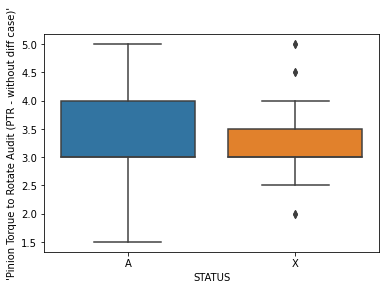

In [70]:

# sns.boxplot(x="STATUS",y="'Ring Gear Press Distance'",data = df_model)
# plt.show()

sns.boxplot(x="STATUS",y="'Pinion Torque to Rotate Audit (PTR - without diff case)'",data = df_model)
plt.show()

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWar

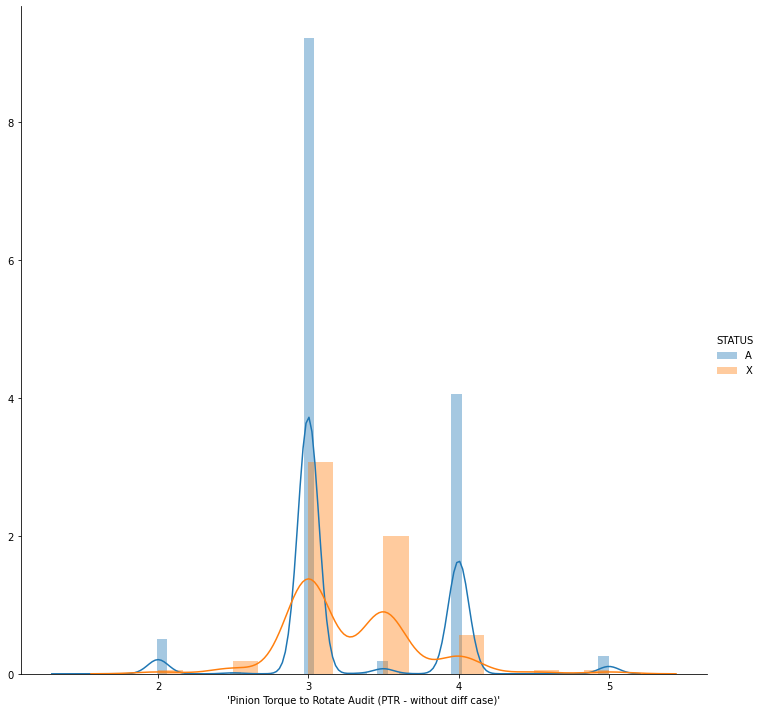

In [89]:
sns.FacetGrid(df_model, hue="STATUS", size = 10).map(sns.distplot,"'Pinion Torque to Rotate Audit (PTR - without diff case)'").add_legend()
# plt.xlim(100, 200)
plt.show()